In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Загрузка данных

In [3]:
data = pd.read_excel('data/data_ford_price.xlsx') 

#  Отбор признаков: мотивация

## Предобработка данных

In [4]:
data = data[['price','year', 'cylinders', 'odometer', 'lat', 'long', 'weather']]
data.dropna(inplace = True)

y = data['price']
x = data.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

## Обучение модели

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4682.957


## Удаление избыточного признака

In [6]:
x.corr()

,year,cylinders,odometer,lat,long,weather
year,1.000000,-0.228437,-0.359593,0.040896,0.060502,-0.062996
cylinders,-0.228437,1.000000,0.169279,0.024482,-0.009373,-0.015944
odometer,-0.359593,0.169279,1.000000,-0.076136,-0.005328,0.065362
lat,0.040896,0.024482,-0.076136,1.000000,-0.174763,-0.897451
long,0.060502,-0.009373,-0.005328,-0.174763,1.000000,0.070837
weather,-0.062996,-0.015944,0.065362,-0.897451,0.070837,1.000000


In [7]:
x.drop('lat', axis = 1, inplace = True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4672.930


Качество модели немного улучшилось

#  Отбор признаков: классификация методов

Методы отбора признаков предназначены для уменьшения количества входных переменных до тех значений, которые наиболее полезны для предсказательной способности модели.

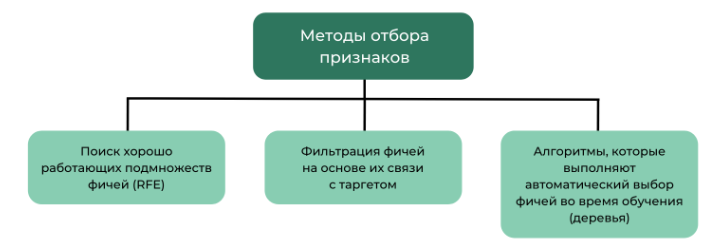

## Метод рекурсивного исключения признаков (RFE)

**Метод рекурсивного исключения признаков (RFE)** предполагает выбор признаков путём рекурсивного рассмотрения всё меньших и меньших наборов фичей.

Сначала RFE обучается на изначальной выборке и происходит оценка важности каждого признака. Затем наименее важные фичи удаляются. Эта процедура рекурсивно повторяется на сокращённом наборе до тех пор, пока в конечном итоге не будет достигнуто желаемое количество признаков в выборке.

In [10]:
from sklearn.feature_selection import RFE

y = data['price']
x = data.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

Выделим три наиболее значимых признака

In [13]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['year', 'cylinders', 'lat'], dtype=object)

Также узнаем, как RFE проранжировал все доступные признаки

In [14]:
X_train.columns

Index(['year', 'cylinders', 'odometer', 'lat', 'long', 'weather'], dtype='object')

In [15]:
selector.ranking_

array([1, 1, 4, 1, 3, 2])

##  Методы выбора признаков на основе фильтров

В качестве фильтров для выбора признаков используются статистики, такие как коэффициент корреляции Пирсона, ANOVA и т. д. При этом выбор статистических показателей сильно зависит от типов переменных в данных.

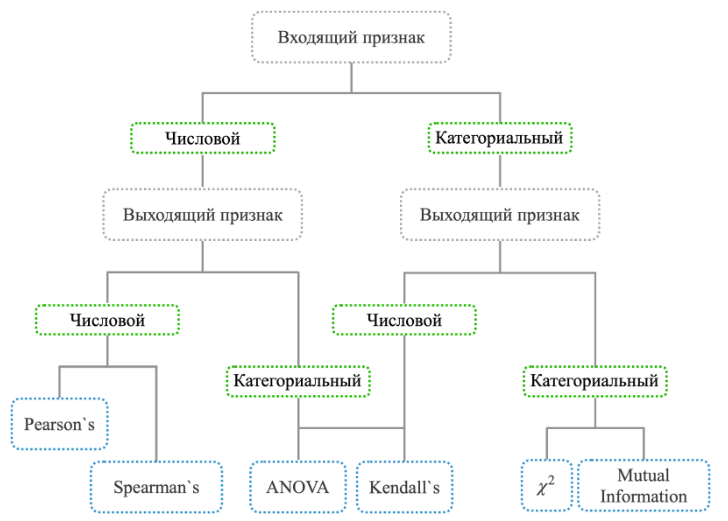

**sklearn** обеспечивает реализацию большинства статистических показателей:
* коэффициент корреляции Пирсона: **f_regression()**;
* дисперсионный анализ ANOVA: **f_classif()**;
* хи-квадрата: **chi2()**;
* взаимная информация: **mutual_info_classif()** и **mutual_info_regression()**.

**SciPy** обеспечивает реализацию многих других статистических данных:
* тау Кендалла (**kendalltau**);
* ранговая корреляция Спирмена (**spearmanr**).

**sklearn** предоставляет методы фильтрации после расчёта статистики для каждой входной переменной с целевой:
* выбор k лучших переменных: **SelectKBest**;
* выбор переменных верхнего процентиля: **SelectPercentile**.

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['year', 'cylinders', 'odometer'], dtype=object)